In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_PINN import *
from NN_library.train_dual_PINN import *
from matplotlib.tri import Triangulation
from utility import *
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_Sobol(14, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 2**14+4)

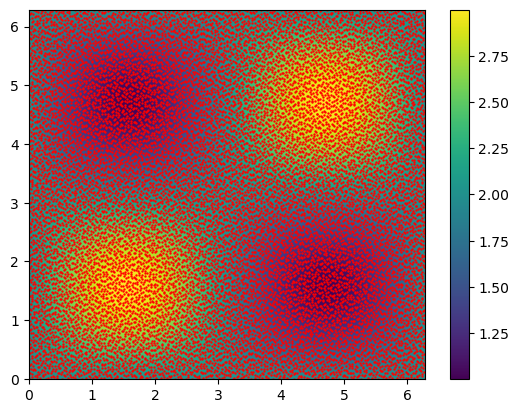

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = 2+np.sin(x)*np.sin(y)
    return a

def A(x):  
    a = (2+torch.sin(x[:,0])*torch.sin(x[:,1])).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = (2+torch.sin(x[:,0])*torch.sin(x[:,1])).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(),XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.5, c='r')

# Primal PINN

In [6]:
net_primal = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 30000, 'dev' : dev, 'name' : f'NN_library/PINN/sin/PINN_primal_{total_params}'}

Number of parameters: 65


In [ ]:
net_primal = load_network(net_primal, args['name']+'_19999', args)
net_primal = net_primal.to(dev)

In [8]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A, H1)

Epoch: 0 mean train loss:  2.53795356e-01, mean val. loss:  2.53840744e-01
Epoch: 1 mean train loss:  2.53775746e-01, mean val. loss:  2.53821254e-01
Epoch: 2 mean train loss:  2.53756285e-01, mean val. loss:  2.53801852e-01
Epoch: 3 mean train loss:  2.53736883e-01, mean val. loss:  2.53782570e-01
Epoch: 4 mean train loss:  2.53717661e-01, mean val. loss:  2.53763407e-01
Epoch: 5 mean train loss:  2.53698468e-01, mean val. loss:  2.53744334e-01
Epoch: 6 mean train loss:  2.53679395e-01, mean val. loss:  2.53725380e-01
Epoch: 7 mean train loss:  2.53660440e-01, mean val. loss:  2.53706515e-01
Epoch: 8 mean train loss:  2.53641576e-01, mean val. loss:  2.53687769e-01
Epoch: 9 mean train loss:  2.53622830e-01, mean val. loss:  2.53669113e-01
Epoch: 10 mean train loss:  2.53604203e-01, mean val. loss:  2.53650606e-01
Epoch: 11 mean train loss:  2.53585696e-01, mean val. loss:  2.53632188e-01
Epoch: 12 mean train loss:  2.53567308e-01, mean val. loss:  2.53613889e-01
Epoch: 13 mean train l

In [10]:
np.save(f'NN_library/training_data/sin/PINN_primal_{total_params}', np.vstack([losses_train, losses_val]))

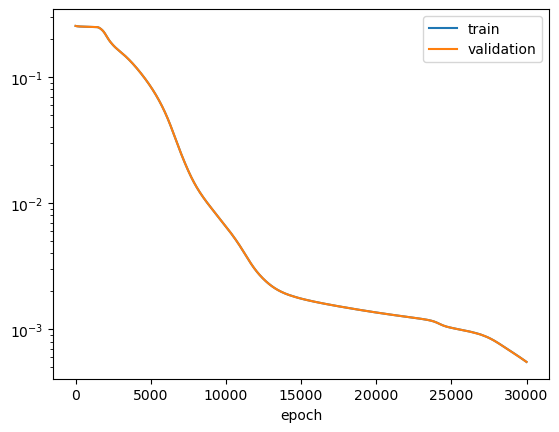

In [9]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [11]:
U1 = net_primal(grid_data).detach().cpu()
error_1 = PDE_loss(grid_data, net_primal, A, H1).detach().cpu()

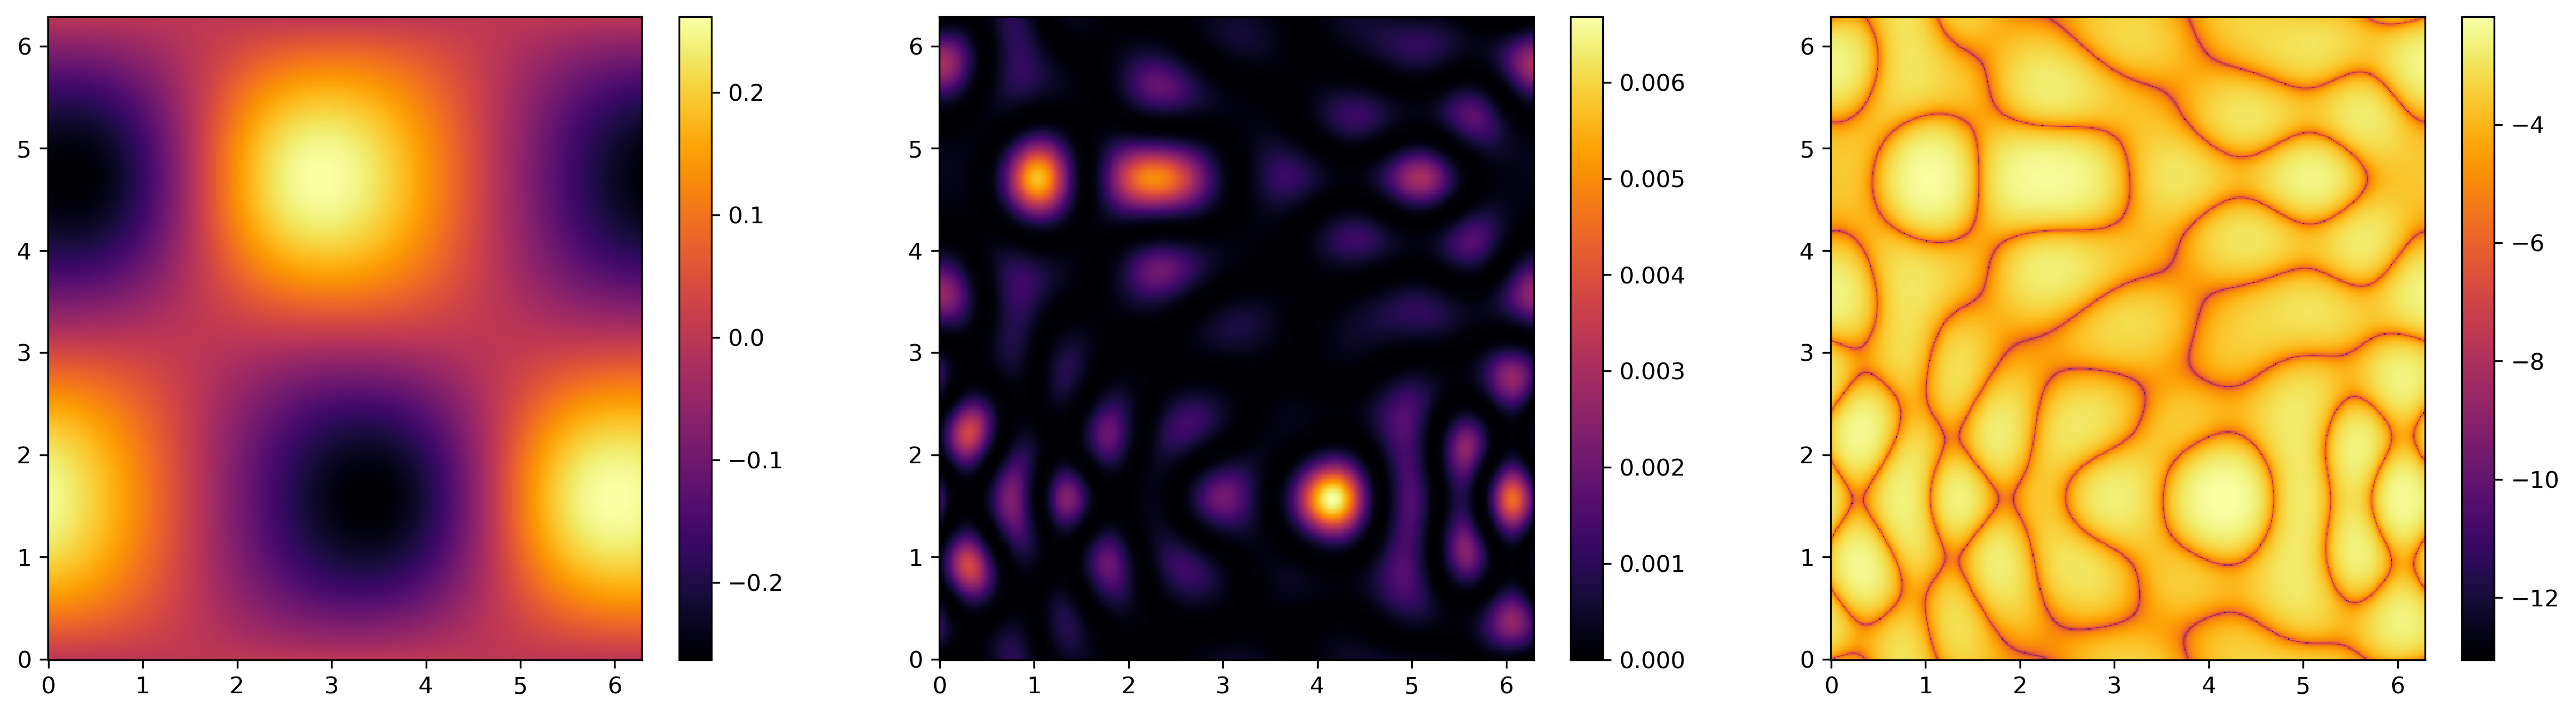

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_1.reshape(N, N)), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [13]:
inputs = data[:].to(dev).requires_grad_(True)
T1 = net_primal(inputs)
dq1 = torch.autograd.grad(
            outputs=T1, inputs=inputs,
            grad_outputs=torch.ones_like(T1)
    )[0].detach()
triang = Triangulation(data[:,0], data[:,1])
n_elem = len(triang.triangles)

In [14]:
A_bound = compute_bound(T1, dq1, triang, inputs, A, H1, L)
print(A_bound[0])
print(A_bound[1])

[[1.93560635e+00]
 [1.94991086e-05]]
[[ 1.98260834e+00]
 [-1.27448026e-04]]


In [15]:
np.save(f'bounds/sin/A_u_NN_{total_params}.npy', A_bound)

## Dual PINN

In [4]:
net_dual = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 30000, 'dev' : dev, 'name' : f'NN_library/PINN/sin/PINN_dual_{total_params}'}

Number of parameters: 65


In [ ]:
net_dual = load_network(net_dual, args['name']+'_29999', args)
net_dual = net_dual.to(dev)

In [5]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_inv, H1, L)

Epoch: 0 mean train loss:  3.40804495e-02, bound:  1.86409974e+00
Epoch: 1 mean train loss:  3.40466164e-02, bound:  1.86410213e+00
Epoch: 2 mean train loss:  3.40128802e-02, bound:  1.86410427e+00
Epoch: 3 mean train loss:  3.39792371e-02, bound:  1.86410677e+00
Epoch: 4 mean train loss:  3.39456983e-02, bound:  1.86410928e+00
Epoch: 5 mean train loss:  3.39122601e-02, bound:  1.86411130e+00
Epoch: 6 mean train loss:  3.38789299e-02, bound:  1.86411381e+00
Epoch: 7 mean train loss:  3.38456929e-02, bound:  1.86411619e+00
Epoch: 8 mean train loss:  3.38125676e-02, bound:  1.86411846e+00
Epoch: 9 mean train loss:  3.37795429e-02, bound:  1.86412084e+00
Epoch: 10 mean train loss:  3.37466262e-02, bound:  1.86412358e+00
Epoch: 11 mean train loss:  3.37138176e-02, bound:  1.86412609e+00
Epoch: 12 mean train loss:  3.36811170e-02, bound:  1.86412823e+00
Epoch: 13 mean train loss:  3.36485244e-02, bound:  1.86413097e+00
Epoch: 14 mean train loss:  3.36160399e-02, bound:  1.86413336e+00
Epoch

In [21]:
np.save(f'NN_library/training_data/sin/PINN_dual_{total_params}', np.vstack([losses_train, losses_val]))

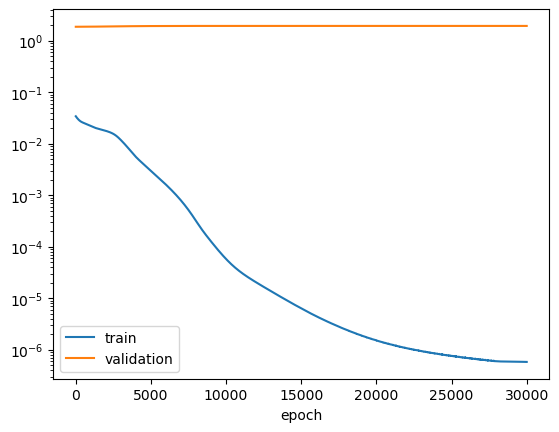

In [8]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [22]:
U2 = net_dual(grid_data).detach().cpu()
error_2 = PDE_loss_dual(grid_data, net_dual, A_inv, H1).detach().cpu()

C:\Users\gaynuliy\AppData\Local\Temp\ipykernel_12048\20050151.py:6: RuntimeWarning: divide by zero encountered in log10
  pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_2.reshape(N, N)), cmap='inferno')


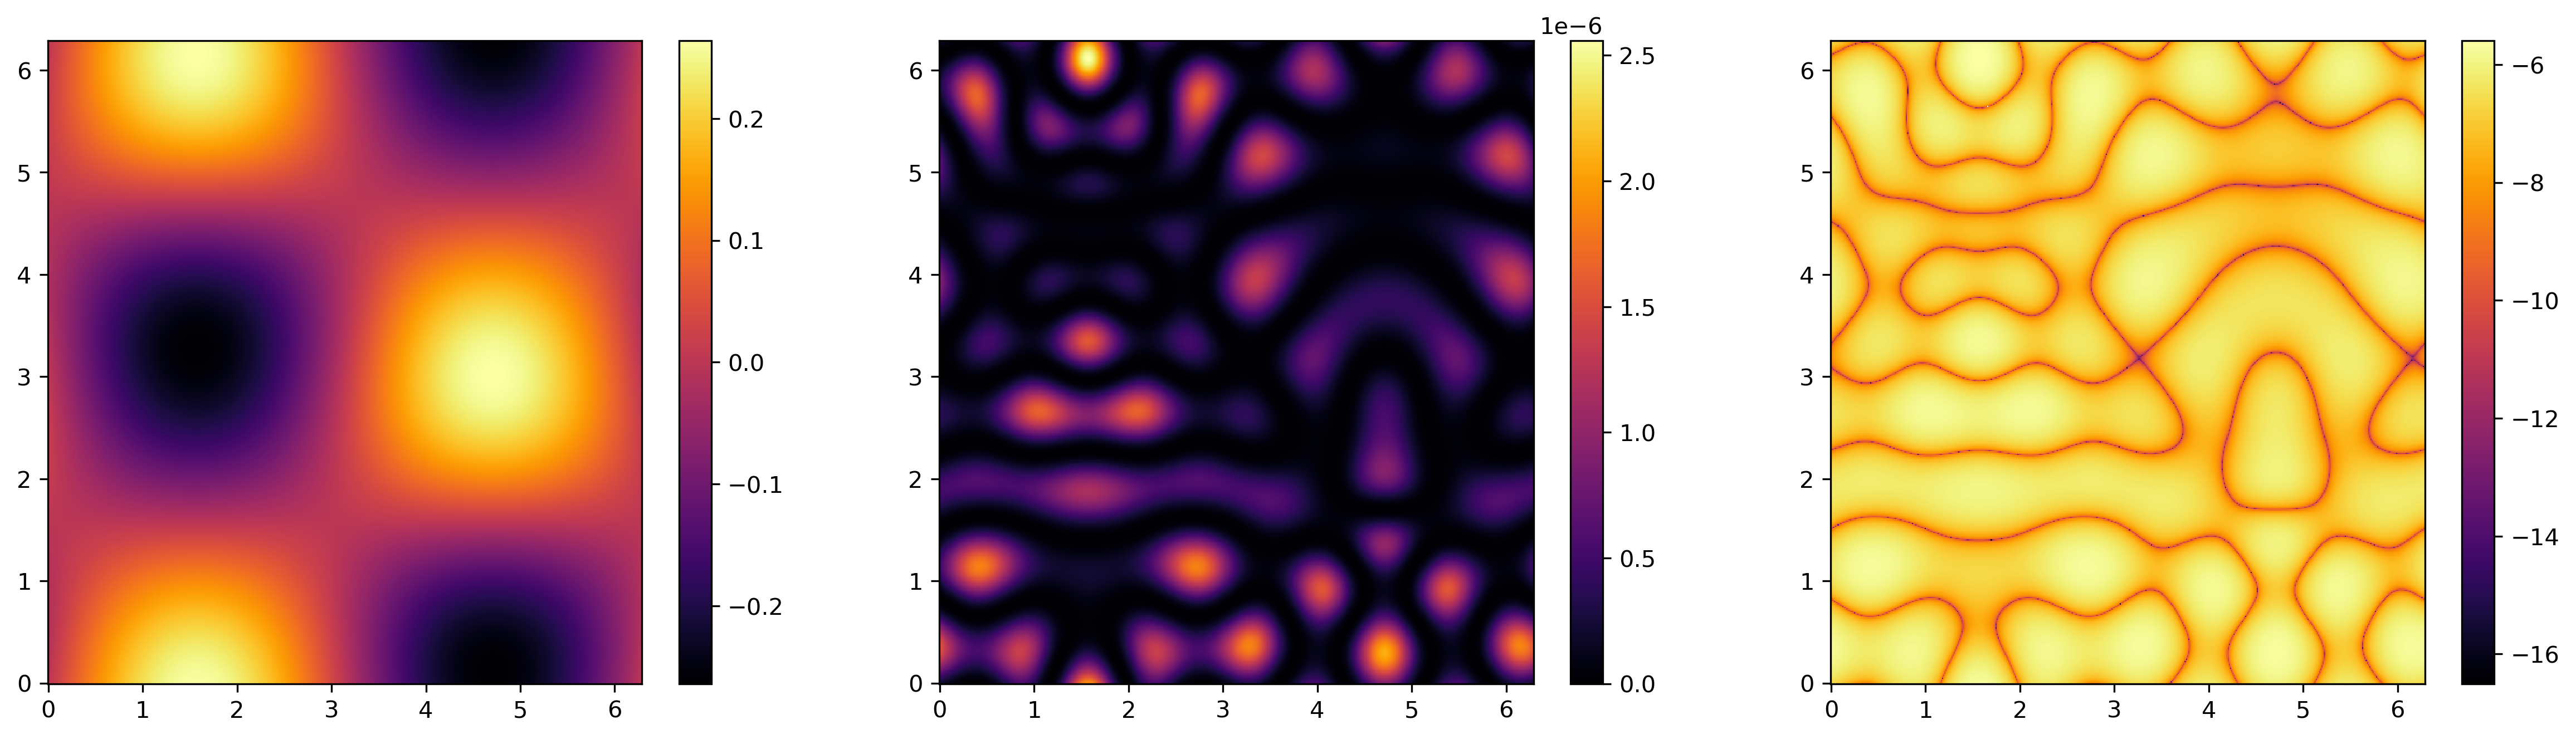

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_2.reshape(N, N)), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [ ]:
inputs = data[:].to(dev).requires_grad_(True)
T2 = net_dual(inputs)
dq2 = torch.autograd.grad(
            outputs=T2, inputs=inputs,
            grad_outputs=torch.ones_like(T2)
    )[0].detach()
curl = torch.zeros_like(dq2)
curl[:,0] = -dq2[:,1]
curl[:,1] = dq2[:,0]
triang = Triangulation(data[:,0], data[:,1])

In [29]:
B = compute_avg(curl, inputs, A_inv, H1)

In [32]:
B

array([5.16698e-01, 3.19664e-05], dtype=float32)

In [35]:
B_bound = compute_bound(T2, curl, triang, inputs, A_inv, H1, L, 'dual')

In [36]:
print(B_bound[0])
print(B_bound[1])

[[ 1.93535978e+00 -2.06142665e-05]
 [-2.06142665e-05  1.93535978e+00]]
[[ 1.89552297 -0.0044278 ]
 [-0.0044278   1.89552297]]


In [37]:
np.save(f'bounds/sin/A_l_PINN_{total_params}.npy', (B_bound[0][0], B_bound[1][0]))